### Imports

In [208]:
# Making imports within the project convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import pandas as pd
import numpy as np
import dataframe_image as dfi
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from src.inference.inference_utils import *

DATA_PATH =  PATH + '/data/Inference/'
sns.set_theme()

### Load data

In [209]:
ctk = pd.read_csv(DATA_PATH + 'ctk.csv')
denik = pd.read_csv(DATA_PATH + 'denik.csv')
lidovky = pd.read_csv(DATA_PATH + 'lidovky.csv')
novinky = pd.read_csv(DATA_PATH + 'novinky.csv')
idnes = pd.read_csv(DATA_PATH + 'idnes.csv')

data = pd.concat([ctk,denik,lidovky,novinky,idnes])

In [210]:
# balance domains by sampling 4k each
sampled_domains = data.groupby('subdomain',as_index=False).apply(lambda x: x.sample(n=4000,random_state=10))

## Bias along domains

In [211]:
# group by domains, for each domain compute mean bias
domains = sampled_domains.groupby('subdomain',as_index=False).agg({'text_bias':'mean','headline_bias':'mean'})

#### text-bias

Text(0, 0.5, 'Average bias of the articles in %')

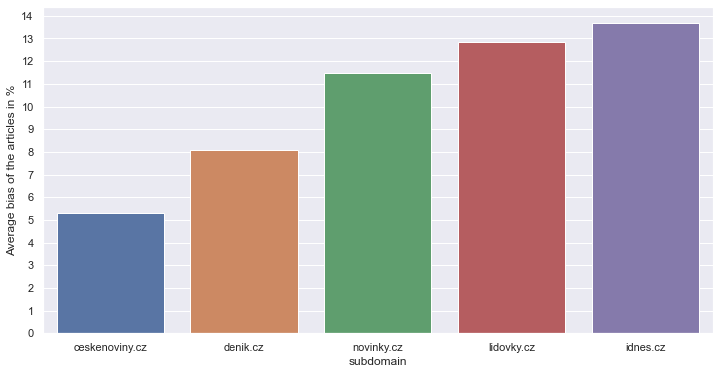

In [212]:
domains = domains.sort_values('text_bias')

ax = plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,20, 1))
sns.barplot(x=domains['subdomain'], y=domains['text_bias'],ci=None)
plt.ylabel('Average bias of the articles in %')

#### headline-bias

Text(0, 0.5, 'Ratio of biased headlines')

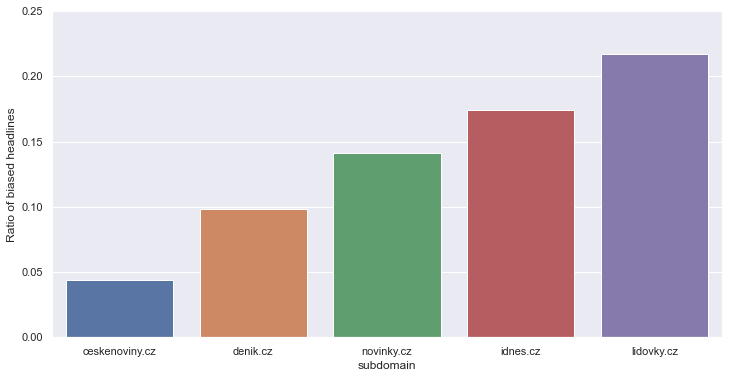

In [213]:
domains = domains.sort_values('headline_bias')

ax = plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,20, 1))
sns.barplot(x=domains['subdomain'], y=domains['headline_bias'],ci=None)
plt.yticks(np.arange(0,0.3,0.05))
plt.ylabel('Ratio of biased headlines')

In [214]:
domains.sort_values(by='text_bias')

,subdomain,text_bias,headline_bias
0,ceskenoviny.cz,5.321041,0.04400
1,denik.cz,8.095943,0.09800
4,novinky.cz,11.460655,0.14125
3,lidovky.cz,12.823196,0.21700
2,idnes.cz,13.696860,0.17400


### Correlations

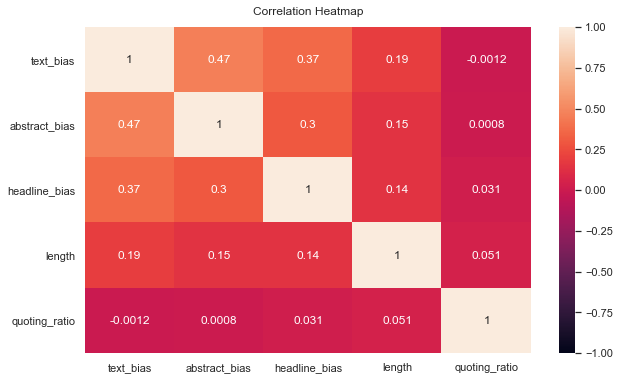

In [215]:
plot_corr(sampled_domains)

### Bias distribution

Distribution of ratio of bias in articles.

Text(0.5, 0, 'Ratio of bias in article in %')

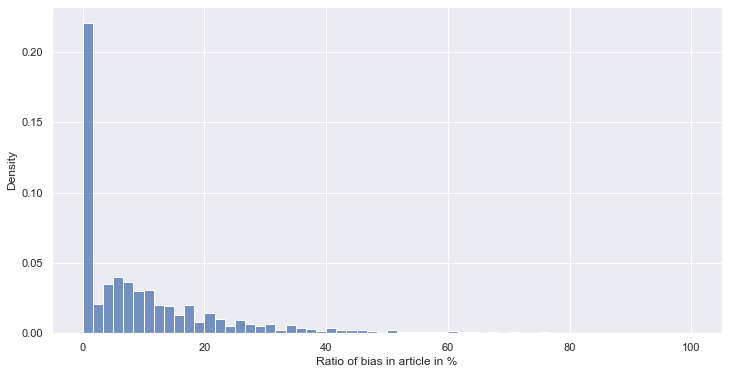

In [216]:
data_dist_w_zero = sampled_domains['text_bias']
ax = plt.figure(figsize=(12,6))
sns.histplot(x=data_dist_w_zero, stat='density',bins=60)
plt.xlabel('Ratio of bias in article in %')

Distribution of ratio of bias in articles without 0.

Text(0.5, 0, 'Ratio of bias in article in %')

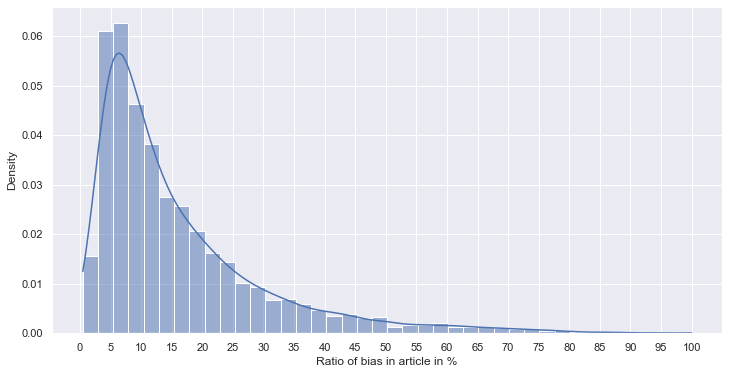

In [217]:
data_dist = sampled_domains[sampled_domains['text_bias']!=0]['text_bias']

ax = plt.figure(figsize=(12,6))
plt.xticks(np.arange(0, 101, 5.0))

#fit gamma dist
#x = np.linspace(0, 100, 100)
#fit_alpha, fit_loc, fit_beta=stats.gamma.fit(data_dist)
#y = stats.gamma.pdf(x,a=fit_alpha,loc=fit_loc,scale=fit_beta)
#plt.plot(x, y)

sns.histplot(x=data_dist, stat="density",kde=True,bins=40)
plt.xlabel('Ratio of bias in article in %')

Comparison between distributions of the least and the most biased domains.

Text(0.5, 0, 'Ratio of bias in article in %')

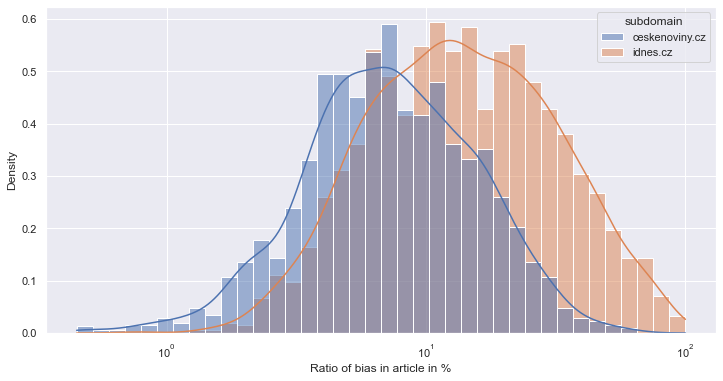

In [123]:
data_dist = sampled_domains[sampled_domains['text_bias']>0]

# plot bias distributions between denik and ctk
ctk_vs_idnes = data_dist[(data_dist['subdomain']=='ceskenoviny.cz') | (data_dist['subdomain']=='idnes.cz')]

ax = plt.figure(figsize=(12,6))

sns.histplot(data=ctk_vs_idnes,x='text_bias', stat="density",log_scale=True,hue='subdomain',kde=True)
plt.xlabel('Ratio of bias in article in %')

## Bias along sections

In [218]:
# remove sections with less than 50 articles
small_sections_out = data[data['section'].groupby(data['section']).transform('size')>=50]

In [219]:
# average text bias along sections
section_bias = small_sections_out.groupby('section').agg({'text_bias':'mean'}).sort_values(by='text_bias')

In [220]:
print('The least biased sections:\n')
section_bias[:10]

The least biased sections:



,text_bias
section,
kariera,3.603703
ekonomika,4.056578
zdravi,4.976201
byznys,5.433510
plzen,5.845502
olomouc,6.190911
finance,6.517701
praha,6.521680
krimi,6.821792


In [221]:
print('The most biased sections:\n')
section_bias[-10:]


The most biased sections:



,text_bias
section,
rungo,21.699309
umeni,21.905913
hudba,22.284284
revue,23.939246
xman,26.156186
bonusweb,28.139390
kultura,32.818075
film,33.497692
plnehry,46.705867


# Denik.cz experiments

Progress of medai bias in denik.cz domain over 10 years.

### In time

In [223]:
# 1) sample news only from section "denik" from 10 years (without 2017 which has only few articles)
denik_sampled = denik[(denik['Year']<2017) & (denik['section']=='denik')].groupby('Year',as_index=False).apply(lambda x: x.sample(n=350,random_state=42))

#### Years

Linear regression over aggregated biases over years.

Text(0.5, 0, 'Years')

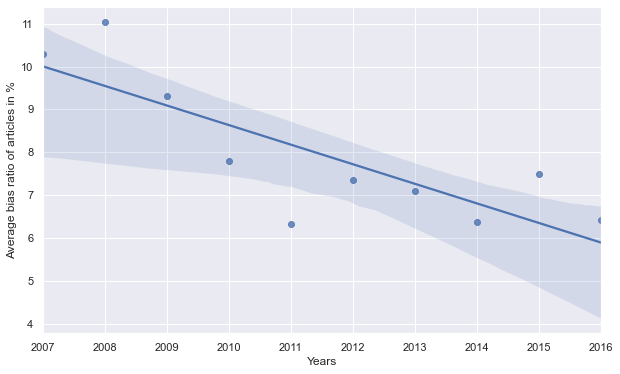

In [226]:
years_bias = denik_sampled.groupby('Year',as_index=False).agg({'text_bias':'mean'})

sns.set_theme(color_codes=True)
ax = plt.figure(figsize=(10,6))
plt.xticks(np.arange(0,10),years_bias['Year'])
sns.regplot(x=np.arange(0,10),y='text_bias',data=years_bias,order=1)
plt.ylabel('Average bias ratio of articles in %')
plt.xlabel('Years')

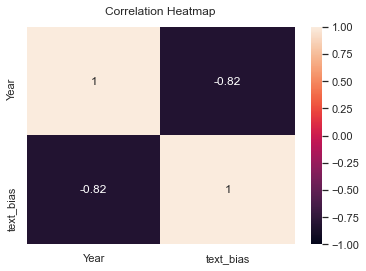

In [227]:
over_time_corr(denik_sampled)

#### Months

Linear regression over aggregated biases over months.

In [228]:
months_bias = denik_sampled.groupby('published',as_index=False).agg({'text_bias':'mean'})
all_years = months_bias['published'].apply(lambda x: str(x)[:4]).to_numpy()
indices = []
years = np.unique(all_years)
for y in years:
    indices.append(np.where(all_years==y)[0][0])

Text(0.5, 0, 'Time')

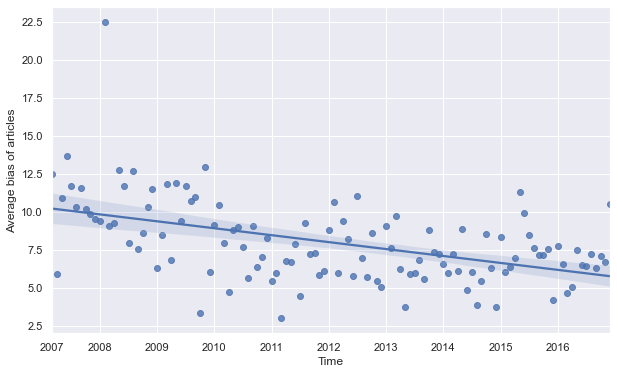

In [229]:
ax = plt.figure(figsize=(10,6))
#plt.yticks(np.arange(0,0.12, 0.01))
plt.xticks(indices,years, rotation='horizontal')
sns.regplot(x=np.arange(0,118),y='text_bias',data=months_bias,order=1)
plt.ylabel('Average bias of articles')
plt.xlabel('Time')


<AxesSubplot:xlabel='published', ylabel='text_bias'>

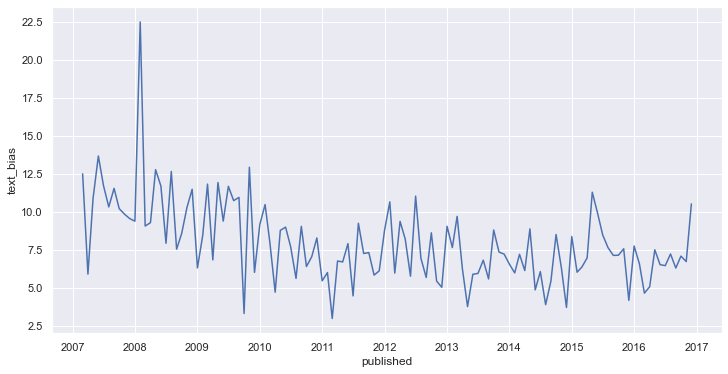

In [230]:
ax = plt.figure(figsize=(12,6))
sns.lineplot(x='published', y='text_bias', data=months_bias)

#### without outlier in 2008

Text(0.5, 0, 'Time')

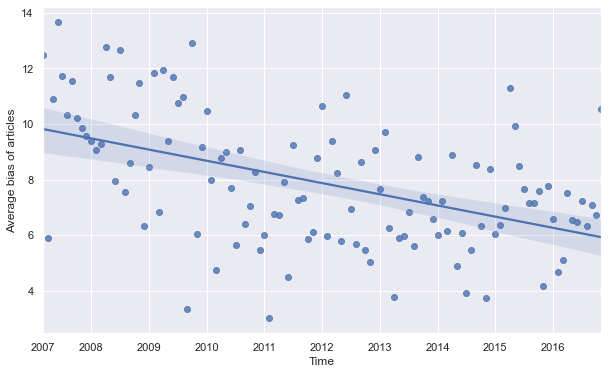

In [231]:
without_outlier = months_bias.drop(months_bias.sort_values('text_bias').iloc[-1].name,axis=0)

ax = plt.figure(figsize=(10,6))
#plt.yticks(np.arange(0,0.12, 0.01))
plt.xticks(indices,years, rotation='horizontal')
sns.regplot(x=np.arange(0,117),y='text_bias',data=without_outlier,order=1)
plt.ylabel('Average bias of articles')
plt.xlabel('Time')


<AxesSubplot:xlabel='published', ylabel='text_bias'>

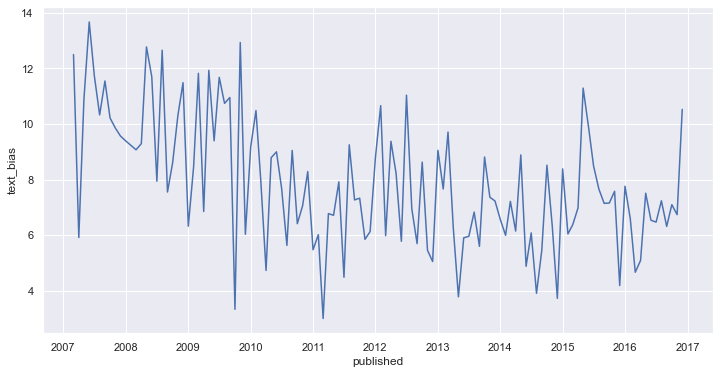

In [232]:
ax = plt.figure(figsize=(12,6))
sns.lineplot(x='published', y='text_bias', data=without_outlier)

## Not included in the thesis

boxplot over years of all data

<AxesSubplot:xlabel='Year', ylabel='text_bias'>

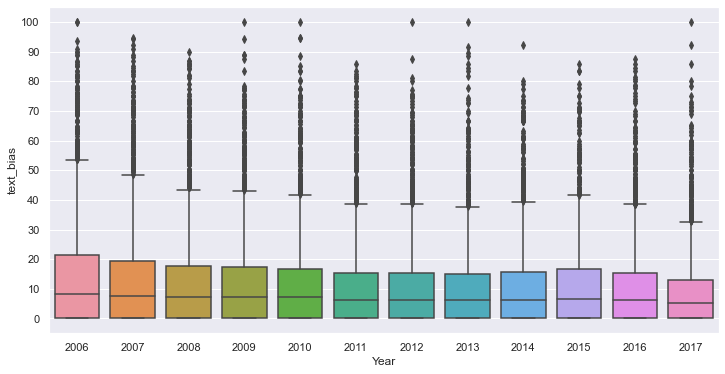

In [161]:
years_sampled = data[data['Year']>2005].groupby('Year',as_index=False).apply(lambda x: x.sample(n=2500,random_state=42))

ax = plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,110,10))
sns.boxplot(x="Year", y="text_bias", data=years_sampled[years_sampled['text_bias']>=0])

#### Ideology bias

In [276]:
searchfor = ['levicový', 'pravicový','levice','pravice','liberální','konvzervativní','Leviový','levicovému','Pravicový','pravicová','levicová','Pravicová','Levicová']

data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,11.392531
True,19.234280
